# Single weight behavior

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pystan
import scipy.stats as stats
import seaborn as sns
import tqdm
import sys

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import initializers
from functools import partial
from numpy import trapz

sns.set(style="darkgrid")
sys.path.append('../')

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )

tfd=tfp.distributions
log=tf.math.log

try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    import sys
    !wget https://raw.githubusercontent.com/stefan1893/VIMLTS/main/src/vimlts_fast.py
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    from src.vimlts_fast import VimltsLinear, ConjungateDenseViGauss


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version:  2.4.1


## Data generating process
Draw samples from a mixture distribution

$y \sim MixtureCauchy(\mu_{0},\sigma, \mu_{1},\sigma)$

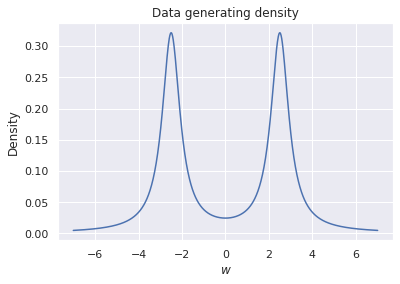

In [16]:
mu_0=2.5
mu_1=-2.5
sigma=sigma_0=sigma_1=0.5
mix=0.5

# Cauchy mixture distribution
a_bimix_cauchy = tfd.Mixture(
  cat=tfd.Categorical(probs=[mix, 1.-mix]),
  components=[
    tfd.Cauchy(loc=mu_0, scale=sigma_0),
    tfd.Cauchy(loc=mu_1, scale=sigma_1),
])

ww=np.linspace(-7.,7.,num=int(1e3))

plt.figure()
plt.plot(ww, a_bimix_cauchy.prob(ww))
plt.title(r'Data generating density')
plt.ylabel(r'Density')
plt.xlabel(r'$w$');

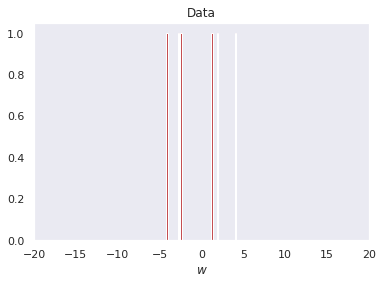

In [3]:
num = 6
tf.random.set_seed(0)
y = a_bimix_cauchy.sample(sample_shape=num)

y=np.array(y).reshape([-1])

plt.hist(y, color='r',bins=50)
plt.xlim([-20,20])
plt.grid()
plt.title(r'Data')
plt.xlabel(r'$w$');

## Ground truth

In [4]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [5]:
stan_code = """
data{
  int<lower=0> N;
  real<lower=0> sigma;
  vector[N] y;
}
parameters{
  real w;
}
model{
  y ~ cauchy(w, sigma);
  w ~ normal(0, 1);
}
"""

mcmc_model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3e6c130a5f8167199a3e917cb6ec796 NOW.


In [6]:
mcmc_data = {'N': num,
        'sigma': sigma,
        'y': y}
mcmc_fit=mcmc_model.sampling(data=mcmc_data,iter=8000,chains=8)

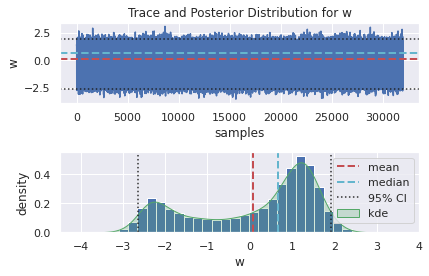

In [7]:
plt.figure()
plot_trace(mcmc_fit.extract()['w'],"w")

In [8]:
print(mcmc_fit.stansummary())

Inference for Stan model: anon_model_b3e6c130a5f8167199a3e917cb6ec796.
8 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=32000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w      0.08    0.03   1.46  -2.64  -1.27   0.67   1.25   1.93   2025    1.0
lp__ -19.28    0.01   0.71 -20.42 -19.81 -19.32 -18.61  -18.4   4584    1.0

Samples were drawn using NUTS at Fri May 21 18:09:45 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## MFVI

### Create a model

In [9]:
# Number of epochs
epochs=200

# Number of samples psi to approximate the expected value
num_samples=10

# Learning rate
lr_start=0.08
lr_end=0.03

# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

ytensor = y.reshape([len(y),1])

In [11]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)

models = {}
theta_start = -5
theta_stop = 5
for M in range(2,15,4):
    # init params
    kernel_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M-1))) for i in range(M-1)])
    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=lambda x: x,
                         **kernel_initializers,
                         num_samples=num_samples,
                         prior_dist=prior_dist,
                         input_shape=(1,),)
    model = tf.keras.Sequential([layer], name=f"VIMLTS-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"VIMLTS - degree:{M}"] = model
model.summary()

class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        kl = [layer.losses[0] for layer in self.model.layers]
        # logs['kl'] = tf.reduce_sum(kl)
        logs['kl'] = kl

def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_nll(y_obs, y_pred, scale=sigma):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    # dist = tfp.distributions.Normal(loc=y_pred, scale=scale)
    dist = tfd.Cauchy(loc=y_pred, scale=scale)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)


Model: "VIMLTS-degree14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_4 (VimltsLinea (10, None, 1)             18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Posterior initial distribution')

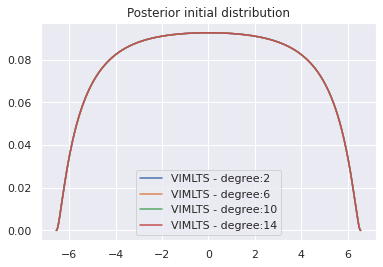

In [12]:
for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist()
    plt.plot(w, qw, label=name, linewidth=1.5)
plt.legend()
plt.title("Posterior initial distribution")

### train the models

In [13]:
for name, model in models.items():
    print(f"Start experiment with model {name}")
    epochs = 20000
    lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=lr_start, lr_stop=lr_end, epochs=epochs))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_start), loss=sample_nll, run_eagerly=False)
    model.fit(tf.ones(ytensor.shape), ytensor, epochs=epochs, verbose=False, callbacks=[lr_callback, LogKL()])


Start experiment with model VIMLTS - degree:2


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Start experiment with model VIMLTS - degree:6
Start experiment with model VIMLTS - degree:10
Start experiment with model VIMLTS - degree:14


(-4.0, 4.0)

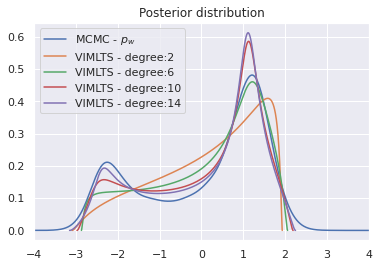

In [18]:
w_MCMC_density_kde = stats.gaussian_kde(mcmc_fit.extract()['w'])
plt.plot(ww,w_MCMC_density_kde(ww),label=r"MCMC - $p_{w}$")
# alpha_post = alpha + np.sum(data)
# beta_post = beta + len(data) - np.sum(data)
# pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
# plt.figure(figsize=(12,6))
# sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label="GT", linewidth=3)

for name, model in models.items():
    layer = model.layers[0]
    qw, w = layer.get_w_dist()
    plt.plot(w, qw, label=name, linewidth=1.5)
plt.legend()
plt.title("Posterior distribution")
plt.xlim((-4,4.))
# plt.savefig("00_conj_prior_posterior.png")

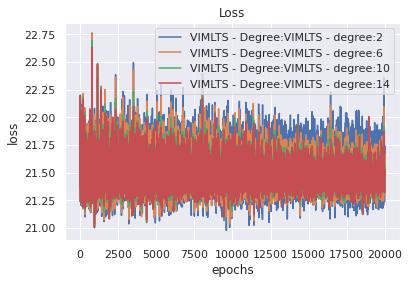

In [22]:
for m, model in models.items():
    plt.plot(model.history.history['epochs'][5:], model.history.history['loss'][5:], label=f"VIMLTS - Degree:{m}")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()